# 3. Prediction 모델링
* 목적
    * 다수의 unlabeled 데이터와 그에 비해 적은 수의 labeled 데이터를 사용한 분류모델 생성
    * 실제 제조업의 불량 검출에 유용하도록 Recall을 최대로 유지

* 참고
    * 본 코드의 실행 결과는 모델 학습의 랜덤성으로 분석 보고서의 결과와 조금의 차이가 있을 수 있습니다.

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



In [4]:
RANDOM_SEED = 42
BATCH_SIZE = 256
EPOCHS = 1000
latent_cnt = 3
ae_model_path = os.path.join('./../model', 'autoencoder.hdf5')

###  Load Datatset

In [45]:
X_train_scaled = pd.read_csv('./../dataset/labeled_X_train_scaled.csv')
X_valid_scaled = pd.read_csv('./../dataset/labeled_X_valid_scaled.csv')
X_test_scaled = pd.read_csv('./../dataset/labeled_X_test_scaled.csv')

y_train = pd.read_csv('./../dataset/labeled_y_train.csv').values.ravel()
y_valid = pd.read_csv('./../dataset/labeled_y_valid.csv').values.ravel()
y_test = pd.read_csv('./../dataset/labeled_y_test.csv').values.ravel()

X_train_arr = X_train_scaled.values
X_valid_arr = X_valid_scaled.values
X_test_arr = X_test_scaled.values


## [Step1. 반지도 학습 모델]

### Calculate class weight
* 불균형 데이터의 학습을 위한 class 가중치를 부여

In [5]:
neg, pos = np.bincount(y_train)
total = neg + pos
# case1
weight_neg = (1 / neg) * (total / 2)
weight_pos = (1 / pos) * (total/2)
class_weight = {0: weight_neg, 1: weight_pos}

### Load Model & Design
* AutoEncoder 모델을 불러와 decoder 부분을 제거
* latent vector를 이용한 예측 모델 학습

In [6]:
ae_model = tf.keras.models.load_model(ae_model_path)
print('AutoEncoder Model')
ae_model.summary()


AutoEncoder Model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 15)                405       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 112       
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 24        
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 28        
_________________________________________________________________
dropout_3 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 

In [27]:
if 'model' in globals():
    del model
model = tf.keras.models.Sequential()
for layer in ae_model.layers[:-4]:
    model.add(layer)

model.build(ae_model.input.shape)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 15)                405       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 112       
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 24        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


In [28]:
current_dense_cnt = len([name for name in model.layers if 'dense' in name.name])
current_dropout_cnt = len([name for name in model.layers if 'dropout' in name.name])
latent_cnt = 3
hidden_dim_1 = latent_cnt

initialize = tf.keras.initializers.HeNormal(RANDOM_SEED)

model.add(tf.keras.layers.Dense(hidden_dim_1, activation='relu', name=f'dense_add_1'))
model.add(tf.keras.layers.Dense(hidden_dim_1, activation='relu', name=f'dense_add_2'))
model.add(tf.keras.layers.Dense(hidden_dim_1, activation='relu', name=f'dense_add_3'))

model.add(tf.keras.layers.Dense(1, activation='sigmoid', name=f'dense_add_4'))

print('Prediction Model')
model.build(ae_model.input.shape)
model.summary()



Prediction Model
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 15)                405       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 112       
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 24        
_________________________________________________________________
dense_add_1 (Dense)          (None, 3)                 12        
_________________________________________________________________
dense_add_2 (Dense)          (None, 3)                 12        
_________________________________________________________________
dense_add_3 (Dense)          (None, 3

### Define Metrics & Callback and Train

In [29]:
# define matric
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS
              )

# set callback
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')
log_path = f'./log/prediction_{yyyymmddHHMM}'
model_dir = f'./prediction_model/model_{yyyymmddHHMM}.hdf5'

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=20,
    verbose=1,
    mode='min',
    restore_best_weights=True
)
save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_dir,
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)
tensorboard = tf.keras.callbacks.TensorBoard(
    log_path,
    update_freq='batch'
)
cb = [early_stop, save_model, tensorboard]

# Training
history = model.fit(
    X_train_arr, y_train,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb
    ,validation_data=(X_valid_arr, y_valid)
    ,class_weight= class_weight
)



Epoch 1/1000
16/16 [==============================] - 1s 79ms/step - loss: 0.6768 - tp: 34.0000 - fp: 3882.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0087 - precision: 0.0087 - recall: 1.0000 - auc: 0.5948 - prc: 0.0182 - val_loss: 0.8056 - val_tp: 15.0000 - val_fp: 1665.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0089 - val_precision: 0.0089 - val_recall: 1.0000 - val_auc: 0.4124 - val_prc: 0.009
Epoch 2/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.6769 - tp: 34.0000 - fp: 3881.0000 - tn: 1.0000 - fn: 0.0000e+00 - accuracy: 0.0089 - precision: 0.0087 - recall: 1.0000 - auc: 0.5965 - prc: 0.0145 - val_loss: 0.8245 - val_tp: 15.0000 - val_fp: 1665.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0089 - val_precision: 0.0089 - val_recall: 1.0000 - val_auc: 0.4911 - val_prc: 0.011
Epoch 3/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6654 - tp: 34.0000 - fp: 3878.0000 - tn: 4.0000 - fn: 0.0000e+00 

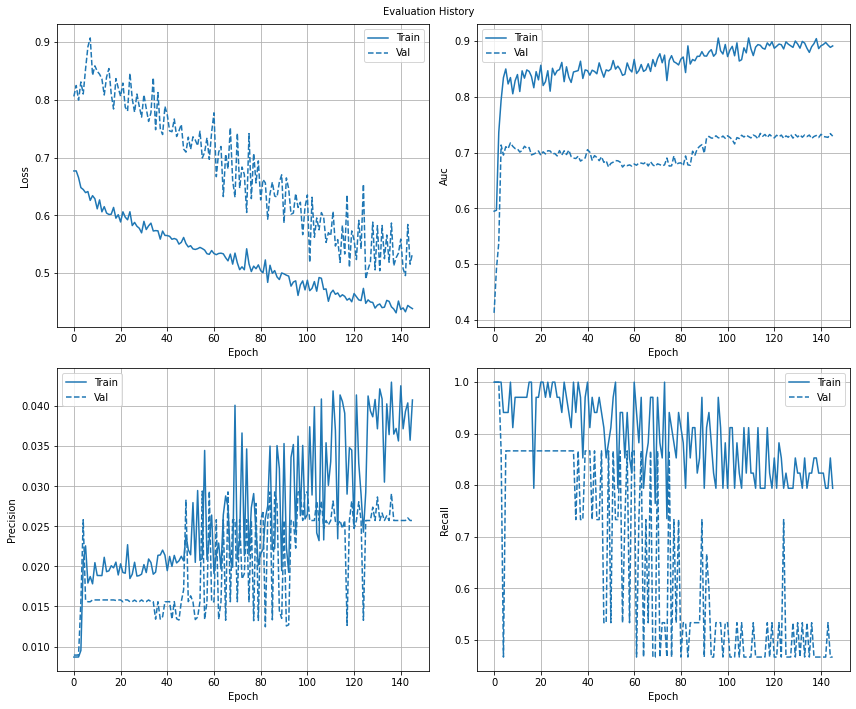

In [31]:
def plot_metric(history: tf.keras.callbacks.History):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle='--', label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)

        plt.legend()
        plt.grid()
    plt.suptitle('Evaluation History', fontsize=10)
    plt.tight_layout()
    plt.show()

plot_metric(history)


### 기존 생성 모델 Load


In [42]:
model_dir = './../model/self_superviser_classifier.hdf5'
model = tf.keras.models.load_model(model_dir)

### Evaluation
* Class 1,0을 판단하는 threshold는 Validation Dataset의 분포로 결정

In [43]:
def print_classification_scores(label, pred):
    precision = precision_score(label, pred)
    recall = recall_score(label, pred)
    f1 = f1_score(label, pred)
    roc_auc = roc_auc_score(label, pred)
    auprc = average_precision_score(label, pred)

    print('Prediction : ', round(precision, 3))
    print('Recall : ', round(recall, 3))
    print('F1 : ', round(f1, 3))
    print('ROC-AUC : ', round(roc_auc, 3))
    print('AUPRC : ', round(auprc, 3))


In [47]:
valid_pred_baseline = model.predict(X_valid_arr, batch_size=BATCH_SIZE)
threshold = np.max(valid_pred_baseline) - 2*(np.std(valid_pred_baseline))
print('Threshold: ', threshold)

y_valid_label = valid_pred_baseline.ravel().copy()
y_valid_label[y_valid_label > threshold] = 1
y_valid_label[y_valid_label <= threshold] = 0

valid_cm = confusion_matrix(y_valid, y_valid_label)
print (' [ Validation Dataset ]')
print(valid_cm)

print_classification_scores(y_valid, y_valid_label)


Threshold:  0.13127046823501587
 [ Validation Dataset ]
[[439 647]
 [  0  13]]
Prediction :  0.02
Recall :  1.0
F1 :  0.039
ROC-AUC :  0.702
AUPRC :  0.02


In [48]:
y_pred = model.predict(X_test_arr)
y_pred_label = y_pred.ravel().copy()
y_pred_label[y_pred_label > threshold] = 1
y_pred_label[y_pred_label <= threshold] = 0

cm = confusion_matrix(y_test, y_pred_label)
print (' [ Test Dataset ]')
print(cm)

print_classification_scores(y_test, y_pred_label)

 [ Test Dataset ]
[[652 900]
 [  0  18]]
Prediction :  0.02
Recall :  1.0
F1 :  0.038
ROC-AUC :  0.71
AUPRC :  0.02


[[652 900]
 [  0  18]]
True Negatives : 652
False Positives : 900
False Negatives : 0
True Positives : 18


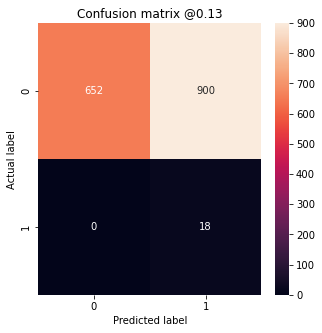

[[439 647]
 [  0  13]]
True Negatives : 439
False Positives : 647
False Negatives : 0
True Positives : 13


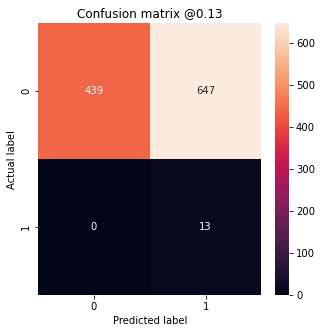

In [49]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions>p)
    print(cm)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion matrix @{p :.2f}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print(f'True Negatives : {cm[0][0]}')
    print(f'False Positives : {cm[0][1]}')
    print(f'False Negatives : {cm[1][0]}')
    print(f'True Positives : {cm[1][1]}')
    plt.show()


train_pred_baseline = model.predict(np.vstack([X_train_arr, X_valid_arr]), batch_size=BATCH_SIZE)
test_pred_baseline = model.predict(X_test_arr)
baseline_results = model.evaluate(X_test_arr, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
cm_threshold = threshold
plot_cm(y_test, test_pred_baseline, cm_threshold)
plot_cm(y_valid, valid_pred_baseline, cm_threshold)



## [ Step2. 분류기]

### 예측 결과에 따른 데이터 추출

In [50]:
def get_confusion_index(label, pred):
    tn_index = np.intersect1d(np.where((label - pred) == 0)[0], np.where(label == 0)[0])
    fn_index = np.where((label - pred) == 1)[0]
    tp_index = np.intersect1d(np.where((label - pred) == 0)[0], np.where(label == 1)[0])
    fp_index = np.where((label - pred) == -1)[0]
    return tn_index, fn_index, tp_index, fp_index

def get_predction_positive_idx(label, pred):
    _,_,tp_index, fp_index = get_confusion_index(label, pred)
    pred_pos_index = np.concatenate([tp_index, fp_index])
    return pred_pos_index

def pred_to_label(pred_data, threshold):
    pred_data_label = pred_data.ravel().copy()
    pred_data_label[pred_data_label > threshold] = 1
    pred_data_label[pred_data_label <= threshold] = 0
    return pred_data_label

def split_data_keep_binary_label_ratio(X:pd.DataFrame, y: pd.Series, split_ratio: float = 0.7)\
    -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):
    Y_index = y[y==0].index
    N_index = y[y==1].index

    Y_train_cnt = int(len(Y_index) * split_ratio)
    N_train_cnt = int(len(N_index) * split_ratio)

    Y_train_idx = np.random.choice(Y_index, Y_train_cnt, replace=False)
    Y_test_idx = np.setdiff1d(Y_index, Y_train_idx)

    N_train_idx = np.random.choice(N_index, N_train_cnt, replace=False)
    N_test_idx = np.setdiff1d(N_index, N_train_idx)

    train_idx = np.random.permutation(np.union1d(Y_train_idx, N_train_idx))
    test_idx = np.random.permutation(np.union1d(Y_test_idx, N_test_idx))

    X_train = X.loc[train_idx, :]
    y_train = y[train_idx]
    X_test = X.loc[test_idx, :]
    y_test = y[test_idx]

    return X_train, y_train, X_test, y_test


# total train
total_train_y = pd.Series(np.concatenate([y_train, y_valid]))
total_train_scaled = pd.concat([X_train_scaled, X_valid_scaled], ignore_index=True)
train_before_pred = model.predict(total_train_scaled.values, batch_size=BATCH_SIZE)
train_before_pred_label = pred_to_label(train_before_pred, threshold)
train_pred_pos_idx = get_predction_positive_idx(total_train_y, train_before_pred_label)

X_train = pd.read_csv('./../dataset/labeled_X_train.csv')
X_valid = pd.read_csv('./../dataset/labeled_X_valid.csv')
total_train_X = pd.concat([X_train, X_valid], ignore_index=True)
total_train_X = total_train_X.loc[train_pred_pos_idx, :]
total_train_y = total_train_y[train_pred_pos_idx]

# split train / validation
rt_X_train, rt_y_train, rt_X_valid, rt_y_valid = split_data_keep_binary_label_ratio(total_train_X, total_train_y)


# test
test_pred_pos_idx = get_predction_positive_idx(y_test, y_pred_label)

X_test = pd.read_csv('./../dataset/labeled_X_test.csv')
rt_X_test = X_test.loc[test_pred_pos_idx, :]
rt_y_test = y_test[test_pred_pos_idx]

### 모델링

In [ ]:
def custom_recall_evaluation(pred, dtrain):
    labels = dtrain.get_label()
    pred[pred>0] = 1
    pred[pred<=0] = 0
    result = recall_score(labels, pred)
    cm = confusion_matrix(labels, pred)
    (tn, fp,
     fn, tp) = cm.flatten()
    return 'custom_fn', fn

neg, pos = np.bincount(rt_y_train)
scale_pos_weight = (neg / pos)*2

model_xgb = xgb.XGBClassifier()
es = xgb.callback.EarlyStopping(rounds=600, maximize=False)
parameters = {
              'learning_rate': [.01, .02, .05, .07, 0.1, 0.15, 0.2, 0.3],
              'max_depth': [1, 2, 3, 5],
              'min_child_weight': [3, 4, 5],
              'silent': [1],
              'subsample': [0.5, 0.6, 0.7],
              'colsample_bytree': [0.6, 0.7, 0.8],
              'n_estimators': [100, 300, 500, 1000],
              'max_delta_step':[0, 1, 3, 5],
              'scale_pos_weight':[scale_pos_weight],
                'random_seed': [3]
              }
best_model = RandomizedSearchCV(model_xgb,
                        parameters,
                        scoring='recall',
                        cv=3,
                        verbose=True)

fit_params={
            'eval_metric': custom_recall_evaluation,
            'callbacks': [es],
            "eval_set": [(rt_X_train, rt_y_train), (rt_X_valid, rt_y_valid)]
            }

best_model.fit(rt_X_train, rt_y_train, **fit_params)
print(best_model.best_params_)

### 기존 생성 모델 Load

In [51]:
c_model_dir = './../model/additional_classifier.pkl'
with open(c_model_dir, 'rb') as f:
    best_model = pickle.load(f)


C:\Users\sherr\anaconda3\envs\kamp_2021\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### 평가

--- validation ---
[[178 470]
 [  0  13]]
--- test ---
[[251 649]
 [  0  18]]
[[178 470]
 [  0  13]]
True Negatives : 178
False Positives : 470
False Negatives : 0
True Positives : 13


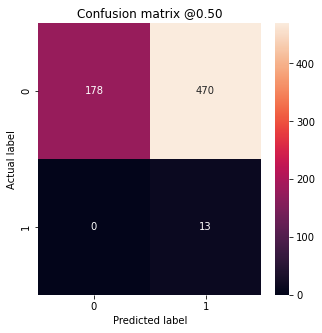

[[251 649]
 [  0  18]]
True Negatives : 251
False Positives : 649
False Negatives : 0
True Positives : 18


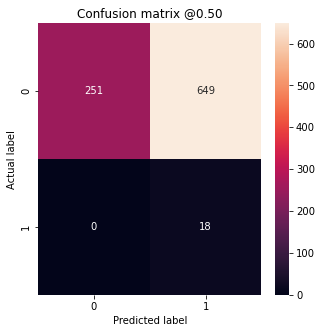

In [53]:
retrain_valid_cm = confusion_matrix(rt_y_valid, best_model.predict(rt_X_valid))
print('--- validation ---')
print(retrain_valid_cm)

rt_pred = best_model.predict(rt_X_test)
retrain_test_cm = confusion_matrix(rt_y_test, rt_pred)
print('--- test ---')
print(retrain_test_cm)

plot_cm(rt_y_valid, best_model.predict(rt_X_valid))
plot_cm(rt_y_test, rt_pred)


### 두 모델 합산 최종 결과

 ---- final validation ---
[[631 455]
 [  0  13]]
[[631 455]
 [  0  13]]
True Negatives : 631
False Positives : 455
False Negatives : 0
True Positives : 13


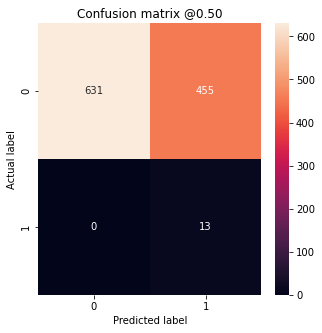

Prediction :  0.028
Recall :  1.0
F1 :  0.054
ROC-AUC :  0.791
AUPRC :  0.028
 ---- test validation ---
[[903 649]
 [  0  18]]
[[903 649]
 [  0  18]]
True Negatives : 903
False Positives : 649
False Negatives : 0
True Positives : 18


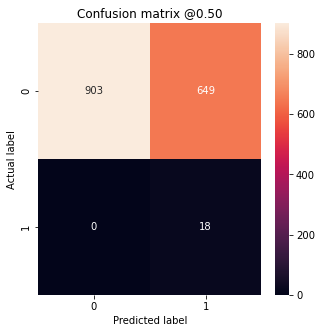

Prediction :  0.027
Recall :  1.0
F1 :  0.053
ROC-AUC :  0.791
AUPRC :  0.027


In [54]:
# valid
final_valid = np.zeros(len(y_valid_label))
valid_tn, valid_fn, valid_tp, valid_fp = get_confusion_index(y_valid, y_valid_label)
rt_valid_idx = np.concatenate([valid_tp, valid_fp])
rt_valid_pred = best_model.predict(X_valid.loc[rt_valid_idx, :])

final_valid[valid_tn] = y_valid_label[valid_tn]
final_valid[rt_valid_idx] = rt_valid_pred

final_valid_cm = confusion_matrix(y_valid, final_valid)
print(' ---- final validation ---')
print(final_valid_cm)
plot_cm(y_valid, final_valid)
print_classification_scores(y_valid, final_valid)

# test
final_test = np.zeros(len(y_pred_label))
test_tn, test_fn, test_tp, test_fp = get_confusion_index(y_test, y_pred_label)
rt_test_idx = np.concatenate([test_tp, test_fp])
rt_test_pred = best_model.predict(X_test.loc[rt_test_idx, :])

final_test[test_tn] = y_pred_label[test_tn]
final_test[rt_test_idx] = rt_test_pred

final_test_cm = confusion_matrix(y_test, final_test)
print(' ---- test validation ---')
print(final_test_cm)
plot_cm(y_test, final_test)
print_classification_scores(y_test, final_test)